<a href="https://colab.research.google.com/github/chrishare/colab_deeplearning/blob/master/vae_keras_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""

Okay, let's build a variational autoencoder. Original code and explanation here:
https://blog.keras.io/building-autoencoders-in-keras.html


We've seen how to build a convolutional autoencoder already. Remember,
autoencoders basically learn a translation to some different 
feature space, by introducing an information bottleneck that forces the
NN to learn a sparse or 'compressed' representation of the input. For instance,
maybe the NN needs to drop some input feautures that are highly correlated with
an input feature it keeps.

A variational autoencoder is a little different. This time, we are learning
a small number of parameter distributions. For instance, we might train a VAE
on a bunch of faces (images) and it might learn variables for the eyes, smile,
haircut, glasses, skin colour, and so on, with the variables taking some
distribution of values that we can sample on to generate new faces. This is 
a generator network, but is not the famous GAN technology (generative adversarial
networks) which consists of a generator and discriminator.

Why is that a good thing? Well, for data generation, a standard autoencoder is
going to produce some latent space that is difficult to understand and 
difficult to interpolate. That is, it's hard with a standard autoencoder to
twiddle a single knob over a well known range of values to get a new instance.
Variational autoencoders help address that through the continuous value 
distribution they produce.

The math here is more complicated. It is similar to a standard autoencoder,
but we need to need to regularise different with Kullback-Liebler Divergence
(KL), which is basically the difference between our latent distribution and
and a target (prior) distribution.
"""

# Import standard python 2 compatablity libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# We need MNIST, various losses, and Input, Dense and Lambda layers.
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# We will need NumPy for some math helpers, matplotlib
import numpy as np
import matplotlib.pyplot as plt

# We might need these two, unless I can remove them soon since this will
# usually run on colab
import argparse
import os



Using TensorFlow backend.


In [0]:
# Some helper functions.

# Reparameterization trick. 
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

# Okay, I do not really understand this math. It looks like we cannot sample
# Q(z|X) for some reason, so we are instead sample from a normal distribution
# around z_mean and z_log_var.

# From what I read here: https://www.quora.com/What-is-the-reparameterization-trick-in-variational-autoencoders
# we need to sample from a distribution that we have the paramters for, since
# we need to differentiate later on.
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    # Whereas K.shape returns a Tensor, int_shape will return a tuple of ints
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

""" This helpers function is going to take the models, test sets, batch size
and a model name, and use it to construct a bunch of images on the filesystem
that show the manifold of instances in latent space, plus samples from that
space.
"""
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.grid(False)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.grid(False)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    #plt.imshow(figure, cmap='Greys_r')
    plt.imshow(figure)
    plt.savefig(filename)
    plt.show()


In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Extract and scale the data, as per normal
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# These are the network parameteres. We have the dimensions from the input
# We'll have a single 512 neuron hidden layer (it's not very deep) but
# two latent dimensions.
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# As per the standard autoencoder, we have two parts to the VAE - an encoder
# and a decoder. Here we build the encoder portion. First, input layer.
inputs = Input(shape=input_shape, name='encoder_input')
# Our single fully connected hidden layer, with relu connections.
x = Dense(intermediate_dim, activation='relu')(inputs)
# Okay, our mean latent layer (mean of the distribution) is connected to h1
z_mean = Dense(latent_dim, name='z_mean')(x)
# And so is the log of the variance. 
z_log_var = Dense(latent_dim, name='z_log_var')(x)

""" Okay, this layer type is new. A Lambda layer basically wraps a function in
a layer, which is handy for non-standard stuff like this sampling operation.
This just 'works' because we've defined the sampling function in terms of
operations that keras knows about (mean, exp, etc) - so it knows how to treat
them when backpropogating the error.
"""
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# This is our encoder Model. It will print a summary of the layers - 400k params.
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# Keras can print a diagram of the model layers to file.
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# Build the decoder, starting with the latent space (2 dim) as input.
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Next a full connected layer with 512 neurons
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
# Final dense layer up to the original input dimensionality.
outputs = Dense(original_dim, activation='sigmoid')(x)

# Build the decoder model. Again, print and vis the model.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# Finally, our VAE model combines the decoder and encoder. This is what we train.
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [4]:
"""
parser = argparse.ArgumentParser()
help_ = "Load h5 model trained weights"
parser.add_argument("-w", "--weights", help=help_)
help_ = "Use mse loss instead of binary cross entropy (default)"
parser.add_argument("-m",
                    "--mse",
                    help=help_, action='store_true')
args = parser.parse_args()
"""
models = (encoder, decoder)
# Get the data for our test set.
data = (x_test, y_test)

mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
# This is our loss. KL divergence plus cross entropy is a good choice here.
if mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

# Scale the reconstruction loss by the number of pixels
reconstruction_loss *= original_dim
# time to actually define the KL loss using our latent variables.
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 86us/step - loss: 197.3793 - val_loss: 172.4732
Epoch 2/50
60000/60000 [==============================] - 4s 68us/step - loss: 169.7215 - val_loss: 167.6533
Epoch 3/50
60000/60000 [==============================] - 4s 68us/step - loss: 165.5753 - val_loss: 164.1203
Epoch 4/50
60000/60000 

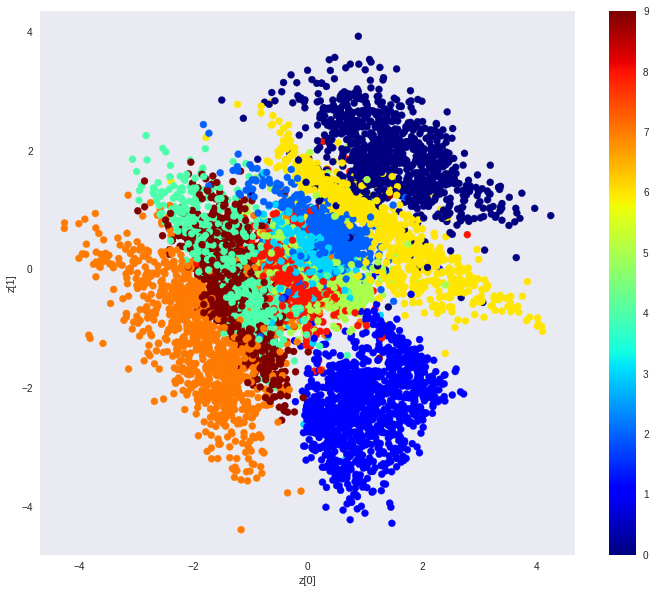

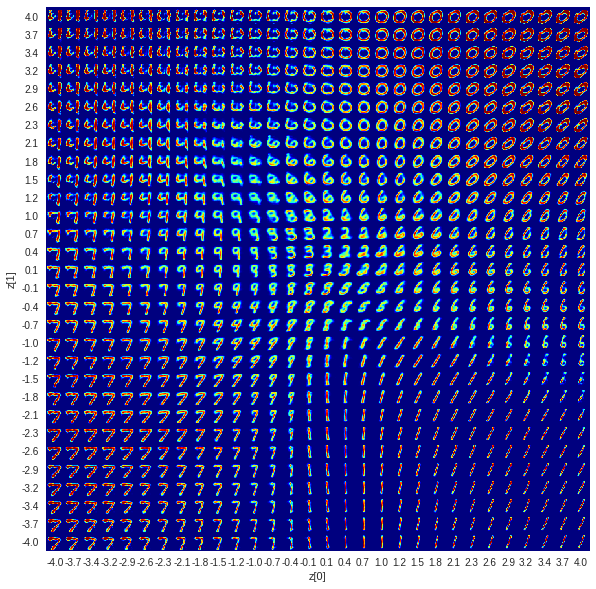

In [5]:
# Okay, should have set the colours above - no matter
import matplotlib.cm as cm
jet = cm.get_cmap('jet')
# Jet is heat colours, from blue to red
plt.set_cmap(jet)
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")